In [2]:
!pip install librosa

In [65]:
!pip install prince

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
import prince
from prince import FAMD

# 2.1 Getting your data 

We want to read the datasets to try to understand which key we can use to merge them together.

First of all we want to fill empty values in the datasets.
The below function take as an input a dataframe and check if in the columns there are any missing values of numeric or string types and fills this value with an empty string, in case of strings, or with a mean of the values of that column in case of numbers.

In [99]:
def filler(dataframe):
    for col in dataframe.columns:
        if dataframe[col].isnull().any():
            if is_string_dtype(dataframe[col]):
                dataframe[col] = dataframe[col].fillna("")
            elif is_numeric_dtype(dataframe[col]):
                dataframe[col] = dataframe[col].fillna(dataframe[col].mean())

We take the datasets needed:

In [100]:
tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

In [101]:
tracks.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [8]:
tracks.shape

(106574, 53)

In [9]:
echonest.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [7]:
echonest.shape

(13129, 250)

In [8]:
features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [102]:
features.shape

(106574, 519)

We can notice that a common column is **track_id**, so let's check if there are any missing values:

In [103]:
tracks["track_id"].isnull().any()

False

In [104]:
echonest["track_id"].isnull().any()

False

In [105]:
features["track_id"].isnull().any()

False

Given that there are no missing values in "**track_id**" columns in any dataset, we choose to use it as the key for the merge of the datasets.

I build a copy and work on it to don't damage the original files.

In [106]:
tracks_c = tracks.copy()
echonest_c = echonest.copy()
features_c = features.copy()

In [107]:
# First we are gonna fill the datasets using the function filler()
filler(tracks_c)
filler(echonest_c)
filler(features_c)

In [51]:
tracks_c.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,,3,,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,,4,,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,...,,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,,6,,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,6,,47632,,...,,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,,1,,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,,...,,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,,3,,[],Spiritual Level


In [93]:
echonest_c.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaT,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaT,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaT,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaT,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [12]:
features_c.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


## 2.2 Choose your features (variables)!

We notice that the number of features is very big (820 columns!) and we want to reduce the number of variables we have to work with.

So let's apply dimensionality reduction!

### Principal Component Analysis

Principal component analysis, is a statistical technique to convert high dimensional data to low dimensional data by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.

#### Standardizing the Numeric Features

Since PCA is effected by scale, we need to scale the features in our data before applying PCA. We used StandardScaler to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of algorithms.First we have to chose numeric and categorical columns.

### Echonest 

In [108]:
# First we need to chose numeric and categorical columns 
num_cols = [col for col in echonest_c.columns if echonest_c[col].dtypes != "O"]
cat_cols = [col for col in echonest_c.columns if echonest_c[col].dtypes == "O"]
cat_cols

['metadata_album_date',
 'metadata_album_name',
 'metadata_artist_location',
 'metadata_artist_name',
 'metadata_release']

In [109]:
[col for col in num_cols if echonest_c[col].dtypes != "float64"]

['track_id']

In [110]:
num_cols.remove('track_id')
#num_cols

In [111]:
# We used PCA for our numerical columns
x = echonest_c.loc[:, num_cols].values
x = StandardScaler().fit_transform(x)

In [112]:
# Initialize the PCA class by passing the number of components to the constructor.
pca = PCA(n_components=2)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca.fit_transform(x)
# Creating Principal data frame
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [113]:
#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  2 ;
Total explained variance =  0.19527


In [114]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.11091527 0.08435649]


#### What if the features are categorical?

PCA works great on continuous data but our data is a blend of both continuous data and categorical data. Sometimes the categorical data is encoded using the one-hot encoding method but it is not recommended. The core idea behind PCA is to determine the components that explain the majority of the variability with the cost of some accuracy. The idea of variability collapses when we have binary data obtained by encoding. PCA may work on the encoded data but that essentially doesn't make it a good analysis.Therefore we decided to use FAMD which is designed to handle the mixed type of data.

#### Factor Analysis of Mixed Data (FAMD)

FAMD does the analysis with a combination of PCA and MCA techniques. MCA stands for Multiple Correspondence Analysis which is suitable for multiple categorical factors specifically. MCA stands for Multiple Correspondence Analysis which is suitable for multiple categorical factors specifically. If the dataset is grouped by different features with a blend of continuous and categorical values, another technique named MFA (Multiple Factor Analysis) can be deployed.

In [134]:
famd = FAMD(n_components =2, n_iter = 3, random_state = 101)
famd.fit(echonest_c)
famd.transform(echonest_c)

,0,1
0,0.098678,0.214209
1,0.340918,0.339411
2,0.179290,0.347700
3,0.322605,-0.051039
4,-0.341341,0.381046
...,...,...
13124,0.456752,0.659565
13125,0.157028,0.686420
13126,0.477453,0.663170
13127,0.100000,0.345955


In [135]:
famd.explained_inertia_

array([0.00075374, 0.00059959])

#### Multiple Correspondence Analysis

Multiple correspondence analysis (MCA) is an extension of correspondence analysis (CA). It should be used when you have more than two categorical variables. The idea is simply to compute the one-hot encoded version of a dataset and apply CA on it.

In [ ]:
# Separating out the features
x = echonest_c[cat_cols]

In [128]:
mca = prince.MCA(n_components=2, n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
mca = mca.fit(x)

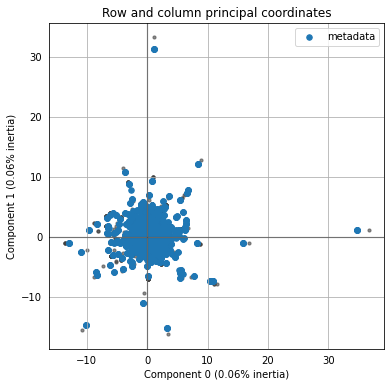

In [129]:
 ax = mca.plot_coordinates(X=x,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1)

In [130]:
mca.eigenvalues_

[0.8917059809909154, 0.8874237374517053]

In [131]:
mca.total_inertia_

1519.2

In [132]:
mca.explained_inertia_

[0.0005869575967554735, 0.0005841388477170256]

In [137]:
cat_cols.append("track_id")

In [138]:
final_echonest = pd.concat([principalDf, echonest_c[cat_cols]], axis = 1)

In [139]:
final_echonest.head(10)

,principal component 1,principal component 2,metadata_album_date,metadata_album_name,metadata_artist_location,metadata_artist_name,metadata_release,track_id
0,0.779174,-1.709545,,,"Georgia, US",AWOL,AWOL - A Way Of Life,2
1,2.659282,-4.168168,,,"Georgia, US",AWOL,AWOL - A Way Of Life,3
2,1.375852,-4.540372,,,"Georgia, US",AWOL,AWOL - A Way Of Life,5
3,6.612735,-1.134204,2008-03-11,Constant Hitmaker,"Philadelphia, PA, US",Kurt Vile,Constant Hitmaker,10
4,-2.917267,-5.523864,,,"Georgia, US",AWOL,AWOL - A Way Of Life,134
5,2.575816,0.521005,,,"Providence, RI, US",Alec K. Redfearn and the Eyesores,Every Man For Himself,139
6,-4.218009,-0.457616,,,"Providence, RI, US",Alec K. Redfearn and the Eyesores,The Blind Spot,140
7,-4.552613,3.990725,,,"Providence, RI, US",Alec K. Redfearn and the Eyesores,Every Man For Himself,141
8,-0.184998,-2.104607,2005,The Quiet Room,"Providence, RI, US",Alec K. Redfearn and the Eyesores,The Quiet Room,142
9,9.028814,-3.333521,,,"Providence, RI, US",Amoebic Ensemble,Amoebiasis,144


### Tracks

In [168]:
# First we need to chose numeric and categorical columns 
num_cols = [col for col in tracks_c.columns if tracks_c[col].dtypes != "O"]
cat_cols = [col for col in tracks_c.columns if tracks_c[col].dtypes == "O"]

In [150]:
# We used PCA for our numerical columns
x = tracks_c.loc[:, num_cols].values
x = StandardScaler().fit_transform(x)

In [162]:
# Initialize the PCA class by passing the number of components to the constructor.
pca = PCA(n_components=2)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca.fit_transform(x)
# Creating Principal data frame
principalDf_T = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [152]:
#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  2 ;
Total explained variance =  0.3765


In [155]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.21837483 0.15812196]


In [169]:
final_tracks = pd.concat([principalDf_T, tracks_c[cat_cols]], axis = 1)

In [170]:
final_tracks.head(10)

,principal component 1,principal component 2,album_date_created,album_date_released,album_engineer,album_information,album_producer,album_tags,album_title,album_type,...,track_genre_top,track_genres,track_genres_all,track_information,track_language_code,track_license,track_lyricist,track_publisher,track_tags,track_title
0,2.068600,-3.083508,2008-11-26 01:44:45,2009-01-05 00:00:00,,<p></p>,,[],AWOL - A Way Of Life,Album,...,Hip-Hop,[21],[21],,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,,,[],Food
1,3.517700,-5.379038,2008-11-26 01:44:45,2009-01-05 00:00:00,,<p></p>,,[],AWOL - A Way Of Life,Album,...,Hip-Hop,[21],[21],,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,,,[],Electric Ave
2,0.963006,-3.172249,2008-11-26 01:44:45,2009-01-05 00:00:00,,<p></p>,,[],AWOL - A Way Of Life,Album,...,Hip-Hop,[21],[21],,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,,,[],This World
3,6.703885,1.335510,2008-11-26 01:45:08,2008-02-06 00:00:00,,,,[],Constant Hitmaker,Album,...,Pop,[10],[10],,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Freeway
4,0.878841,-1.118470,2008-11-26 01:45:05,2009-01-06 00:00:00,,"<p> ""spiritual songs"" from Nicky Cook</p>",,[],Niris,Album,...,,"[76, 103]","[17, 10, 76, 103]",,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Spiritual Level
5,-3.553966,-2.000756,2008-11-26 01:45:05,2009-01-06 00:00:00,,"<p> ""spiritual songs"" from Nicky Cook</p>",,[],Niris,Album,...,,"[76, 103]","[17, 10, 76, 103]",,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Where is your Love?
6,-6.195370,-3.702419,2008-11-26 01:45:05,2009-01-06 00:00:00,,"<p> ""spiritual songs"" from Nicky Cook</p>",,[],Niris,Album,...,,"[76, 103]","[17, 10, 76, 103]",,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Too Happy
7,-9.431718,3.009866,2008-11-26 01:45:05,2009-01-06 00:00:00,,"<p> ""spiritual songs"" from Nicky Cook</p>",,[],Niris,Album,...,,"[76, 103]","[17, 10, 76, 103]",,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Yosemite
8,-2.346873,-1.912763,2008-11-26 01:45:05,2009-01-06 00:00:00,,"<p> ""spiritual songs"" from Nicky Cook</p>",,[],Niris,Album,...,,"[76, 103]","[17, 10, 76, 103]",,en,Attribution-NonCommercial-NoDerivatives (aka M...,,,[],Light of Light
9,0.713103,-6.837377,2008-11-26 01:44:45,2009-01-05 00:00:00,,<p></p>,,[],AWOL - A Way Of Life,Album,...,Hip-Hop,[21],[21],,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,,,[],Street Music


### Features

In [157]:
# First we need to chose numeric and categorical columns 
num_cols = [col for col in features_c.columns if features_c[col].dtypes != "O"]
cat_cols = [col for col in features_c.columns if features_c[col].dtypes == "O"]

In [158]:
# We used PCA for our numerical columns
x = features_c.loc[:, num_cols].values
x = StandardScaler().fit_transform(x)

In [171]:
# Initialize the PCA class by passing the number of components to the constructor.
pca = PCA(n_components=2)
# Call the fit and then transform methods by passing the feature set to these methods. 
# The transform method returns the specified number of principal components.
principalComponents = pca.fit_transform(x)
# Creating Principal data frame
principalDf_F = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [172]:
#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  2 ;
Total explained variance =  0.18748


In [173]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.11958374 0.06789396]


In [177]:
# Separating out the features
x = tracks_c[cat_cols]

In [178]:
mca = prince.MCA(n_components=2, n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
mca = mca.fit(x)

MemoryError: Unable to allocate 896. GiB for an array with shape (106574, 35) and data type <U64471

In [ ]:
mca.explained_inertia_

Once we got all the datasets well filled, we can start merging them using as key the **track_id** column.

In [ ]:
final = tracks_c.merge(features_c.merge(echonest_c, on = "track_id"), on = "track_id")
print(final.shape)
final.head()

As we can see, the number of rows is almost 13k, as demanded.

In [ ]:
# We changed the types of columns as float to apply Standard Scaler
echonest_c[echonest_c.columns] = echonest_c[echonest_c.columns].astype(float)